# [regionmask](https://regionmask.readthedocs.io/en/stable/)
Per Halvorsen <br>
2025-01-01 <br>
[GitHub](https://github.com/pmhalvor) | [LinkedIn](https://linkedin.com/in/pmhalvor) | [Website](https://perhalvorsen.com)


In [gis_intro.ipynb](gis_intro.ipynb) we used [geojson](https://geojson.io/) to define regions of interest, giving us the flexibility to define regions as we see fit.
An alternative here could have been to use [regionmask](https://regionmask.readthedocs.io/en/stable/), a Python library that provides predefined regions for scientific purposes.

While region masking could be useful for other projects, we decided to not use it for this project.
Such scientific regions coculd be useful if we want to measure whale migrations from one region to another, but that was downprioritized for this project. 

I'll keep the exploration code here for future reference.


## Scientific regions
We'll use a scientific region defined in regionmask's documentation: https://regionmask.readthedocs.io/en/stable/defined_scientific.html

In [1]:
import numpy as np
import regionmask
import xarray as xr
import matplotlib.pyplot as plt


In [2]:
regionmask.defined_regions.ar6.all

<regionmask.Regions 'AR6 reference regions'>
Source:   Iturbide et al., 2020 (ESSD)
overlap:  False

Regions:
 0 GIC      Greenland/Iceland
 1 NWN      N.W.North-America
 2 NEN      N.E.North-America
 3 WNA        W.North-America
 4 CNA        C.North-America
..  ..                    ...
53 ARS            Arabian-Sea
54 BOB          Bay-of-Bengal
55 EIO Equatorial.Indic-Ocean
56 SIO          S.Indic-Ocean
57 SOO         Southern-Ocean

[58 regions]

<GeoAxes: >

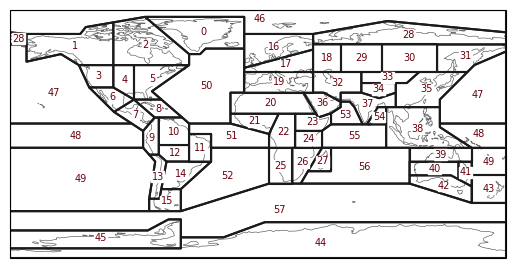

In [3]:
text_kws = dict(color="#67000d", fontsize=7, bbox=dict(pad=0.2, color="w"))

regionmask.defined_regions.ar6.all.plot(
    text_kws=text_kws, label_multipolygon="all"
)

In [4]:
region = regionmask.defined_regions.ar6.all[47]
region

<regionmask._OneRegion: N.Pacific-Ocean (NPO / 47)>

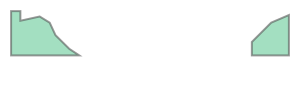

In [5]:
region.polygon

In [6]:
region.coords

array([[ 132.        ,    7.6       ],
       [ 132.        ,    8.035     ],
       [ 132.        ,    8.47      ],
       ...,
       [-179.12139303,    7.6       ],
       [-179.56069652,    7.6       ],
       [-180.        ,    7.6       ]], shape=(1027, 2))

## Filter geodata w/ region mask

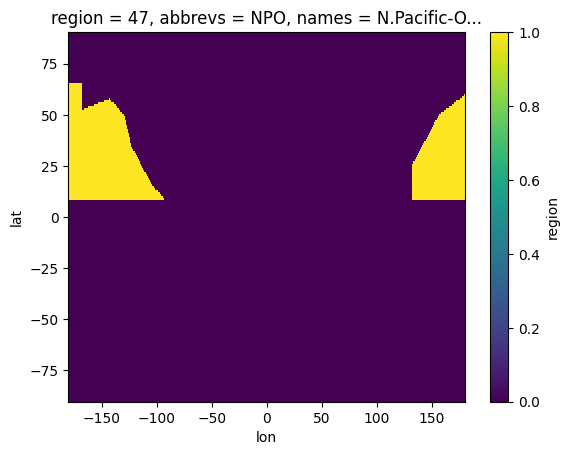

In [7]:
ar6_regions = regionmask.defined_regions.ar6.all

# dataset spanning the globe
globe_xr = xr.Dataset(
    {
        "lon": (["lon"], np.linspace(-179.99, 180, 360)),
        "lat": (["lat"], np.linspace(-90, 90, 180)),
    }
)

# create all possible masks over dataset
ar6_mask = ar6_regions.mask_3D(globe_xr)

# select desired region
ar6_mask.sel(region=47).plot()


In [8]:
# display xr dataset correlated to region mask
ar6_mask.sel(region=47)

<xarray.DataArray 'mask' (lat: 180, lon: 360)> Size: 65kB
array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]], shape=(180, 360))
Coordinates:
  * lat      (lat) float64 1kB -90.0 -88.99 -87.99 -86.98 ... 87.99 88.99 90.0
  * lon      (lon) float64 3kB -180.0 -179.0 -178.0 -177.0 ... 178.0 179.0 180.0
    region   int64 8B 47
    abbrevs  <U4 16B 'NPO'
    names    <U25 100B 'N.Pacific-Ocean'
Attributes:
    standard_name:  region

## earthkit data

Repeat steps above, but using the cached earthkit data as an xarray dataset.

Note: The data is cached from downloading in [gis_intro.ipynb](gis_intro.ipynb). When running this on your own, you'll need to redownload data from the API, and print/copy the path to the cached data.

In [13]:
ds_path = '/tmp/tmptacb1_eq/ads-retriever-f5c106c0db93736042f233ebbd5bf5ef5119c7a4c943338308f26655ccc3399e.cache'

ds_xr = xr.open_dataset(ds_path, engine='cfgrib')

ds_xr

<xarray.Dataset> Size: 4MB
Dimensions:     (time: 8, latitude: 162, longitude: 187)
Coordinates:
    number      int64 8B ...
  * time        (time) datetime64[ns] 64B 2016-12-21 ... 2016-12-22T18:00:00
    step        timedelta64[ns] 8B ...
    surface     float64 8B ...
  * latitude    (latitude) float64 1kB 70.75 70.0 69.25 ... -48.5 -49.25 -50.0
  * longitude   (longitude) float64 1kB 150.0 150.8 151.5 ... 288.0 288.8 289.5
    valid_time  (time) datetime64[ns] 64B ...
Data variables:
    pm10        (time, latitude, longitude) float32 969kB ...
    t2m         (time, latitude, longitude) float32 969kB ...
    msl         (time, latitude, longitude) float32 969kB ...
    tcco        (time, latitude, longitude) float32 969kB ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-01-01T16:27 GRIB to CDM+CF via cfgrib-0.9.1...

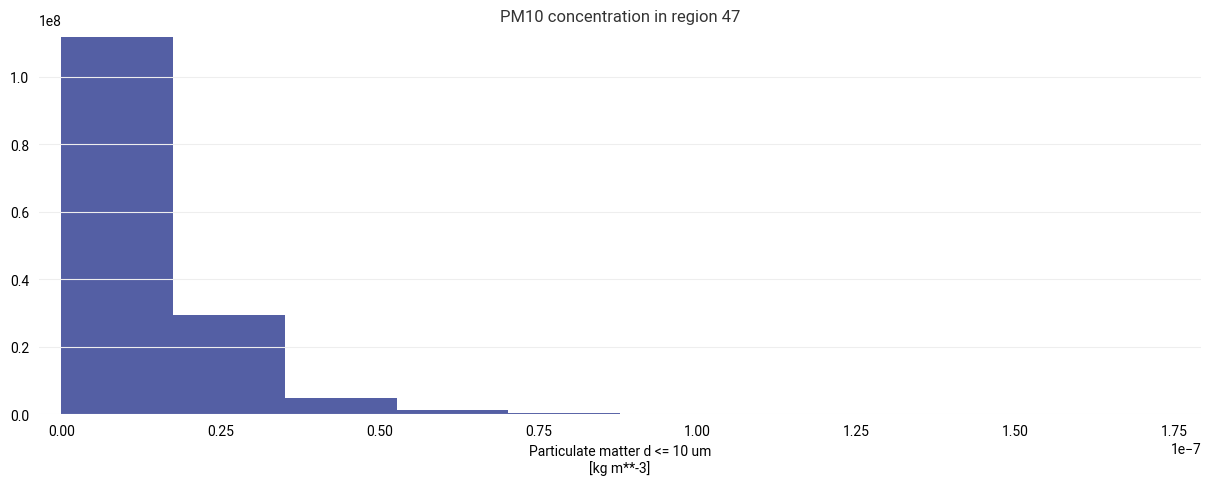

In [9]:
# Apply the global mask to the climate data
masked_climate_data = ds_xr.isel(time=0).where(ar6_mask.sel(region=47))

# Plot the masked data
fig = masked_climate_data["pm10"].plot(figsize=(15, 5))
plt.title("PM10 concentration in region 47")
plt.show()

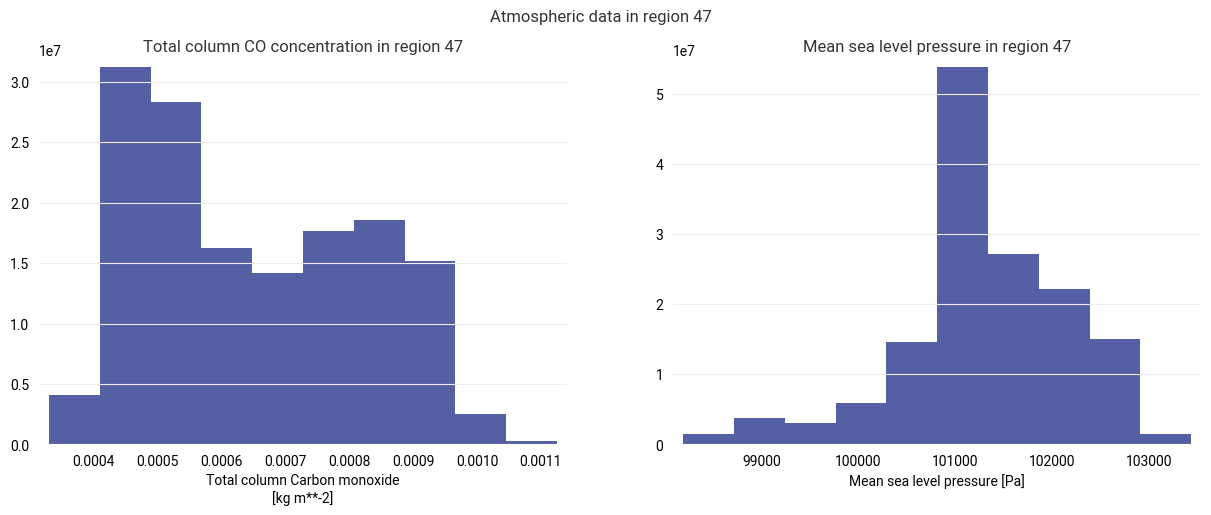

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

masked_climate_data["tcco"].plot(ax=ax[0])
ax[0].set_title("Total column CO concentration in region 47")

masked_climate_data["msl"].plot(ax=ax[1])
ax[1].set_title("Mean sea level pressure in region 47")

fig.suptitle("Atmospheric data in region 47")

plt.show()

## Iterate over interesting regions

47 0 pm10 B
47 1 tcco C
47 2 msl D
47 3 t2m E


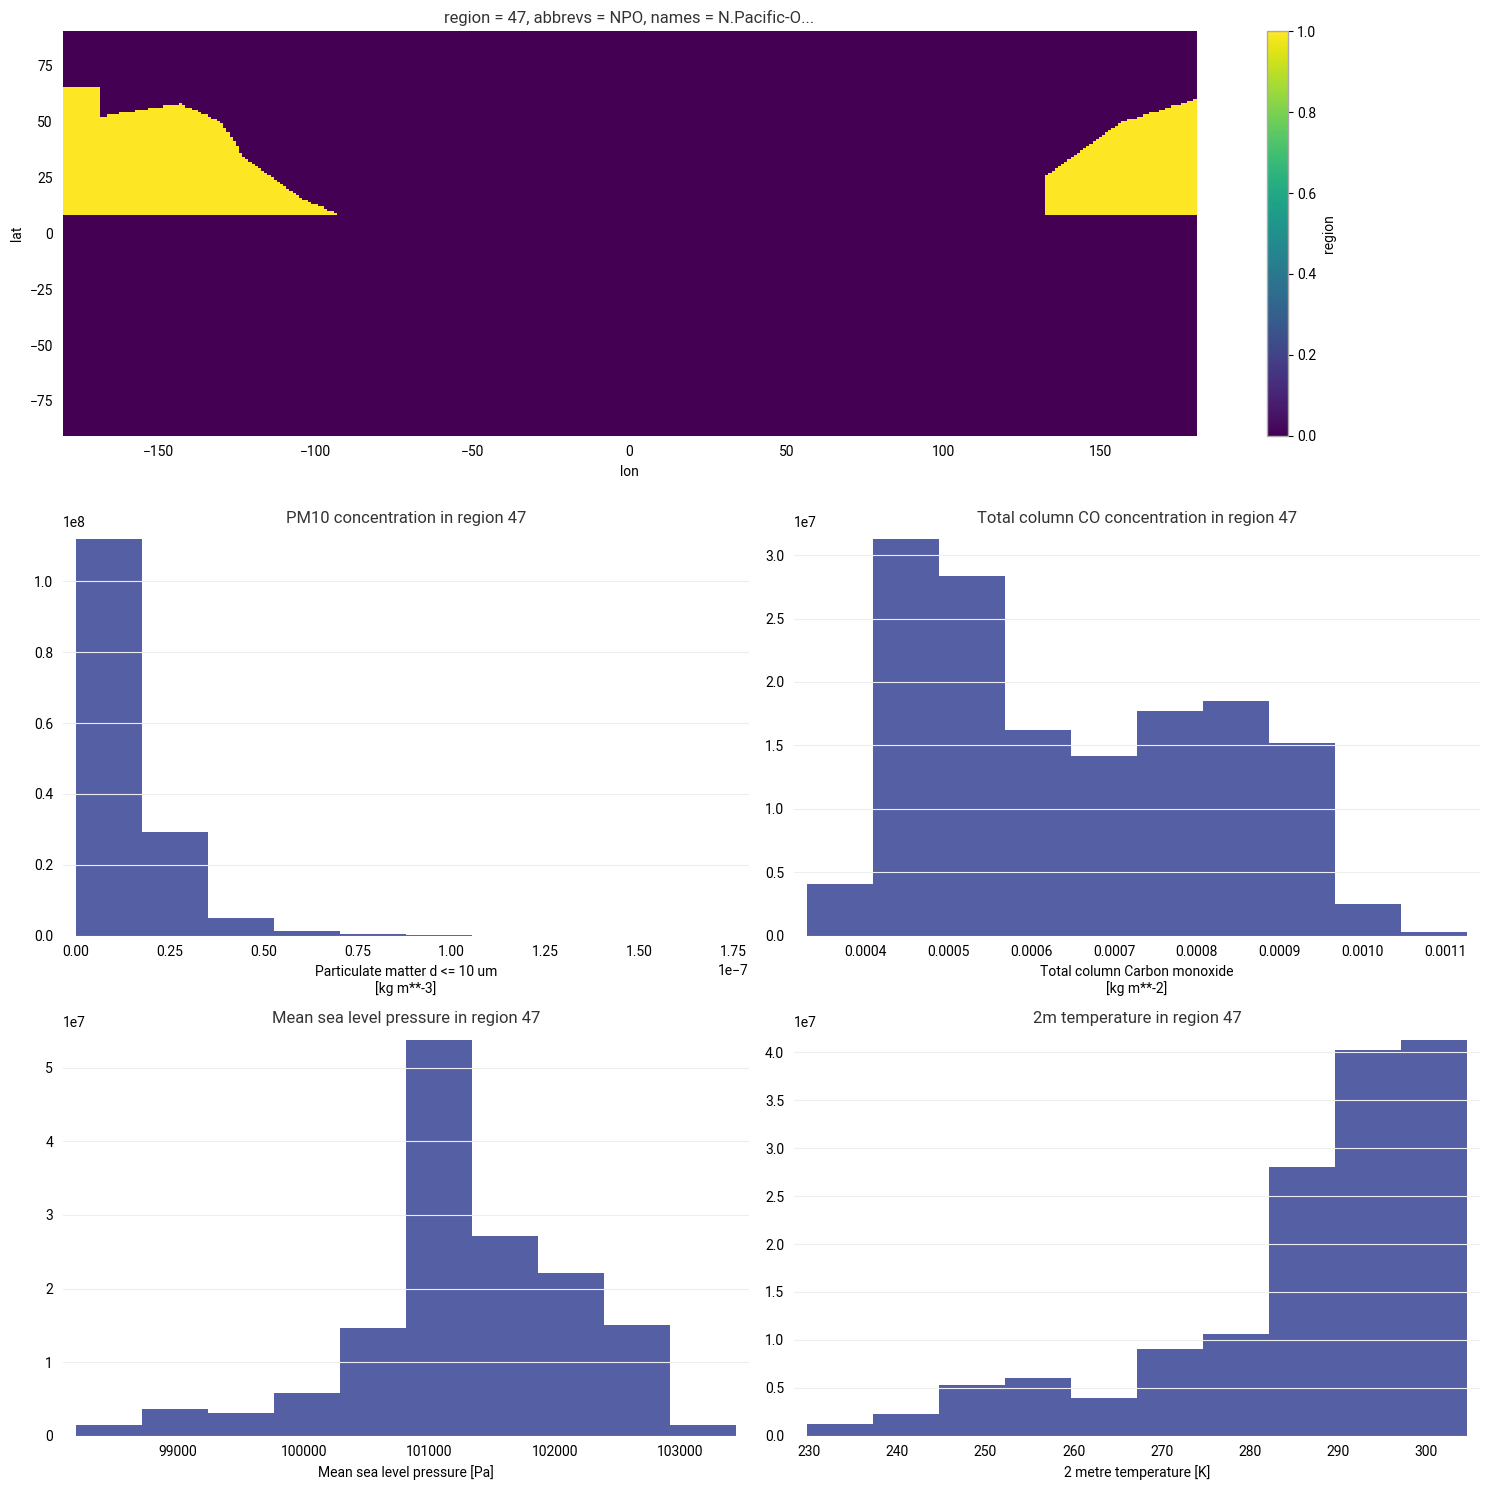

48 0 pm10 B
48 1 tcco C
48 2 msl D
48 3 t2m E


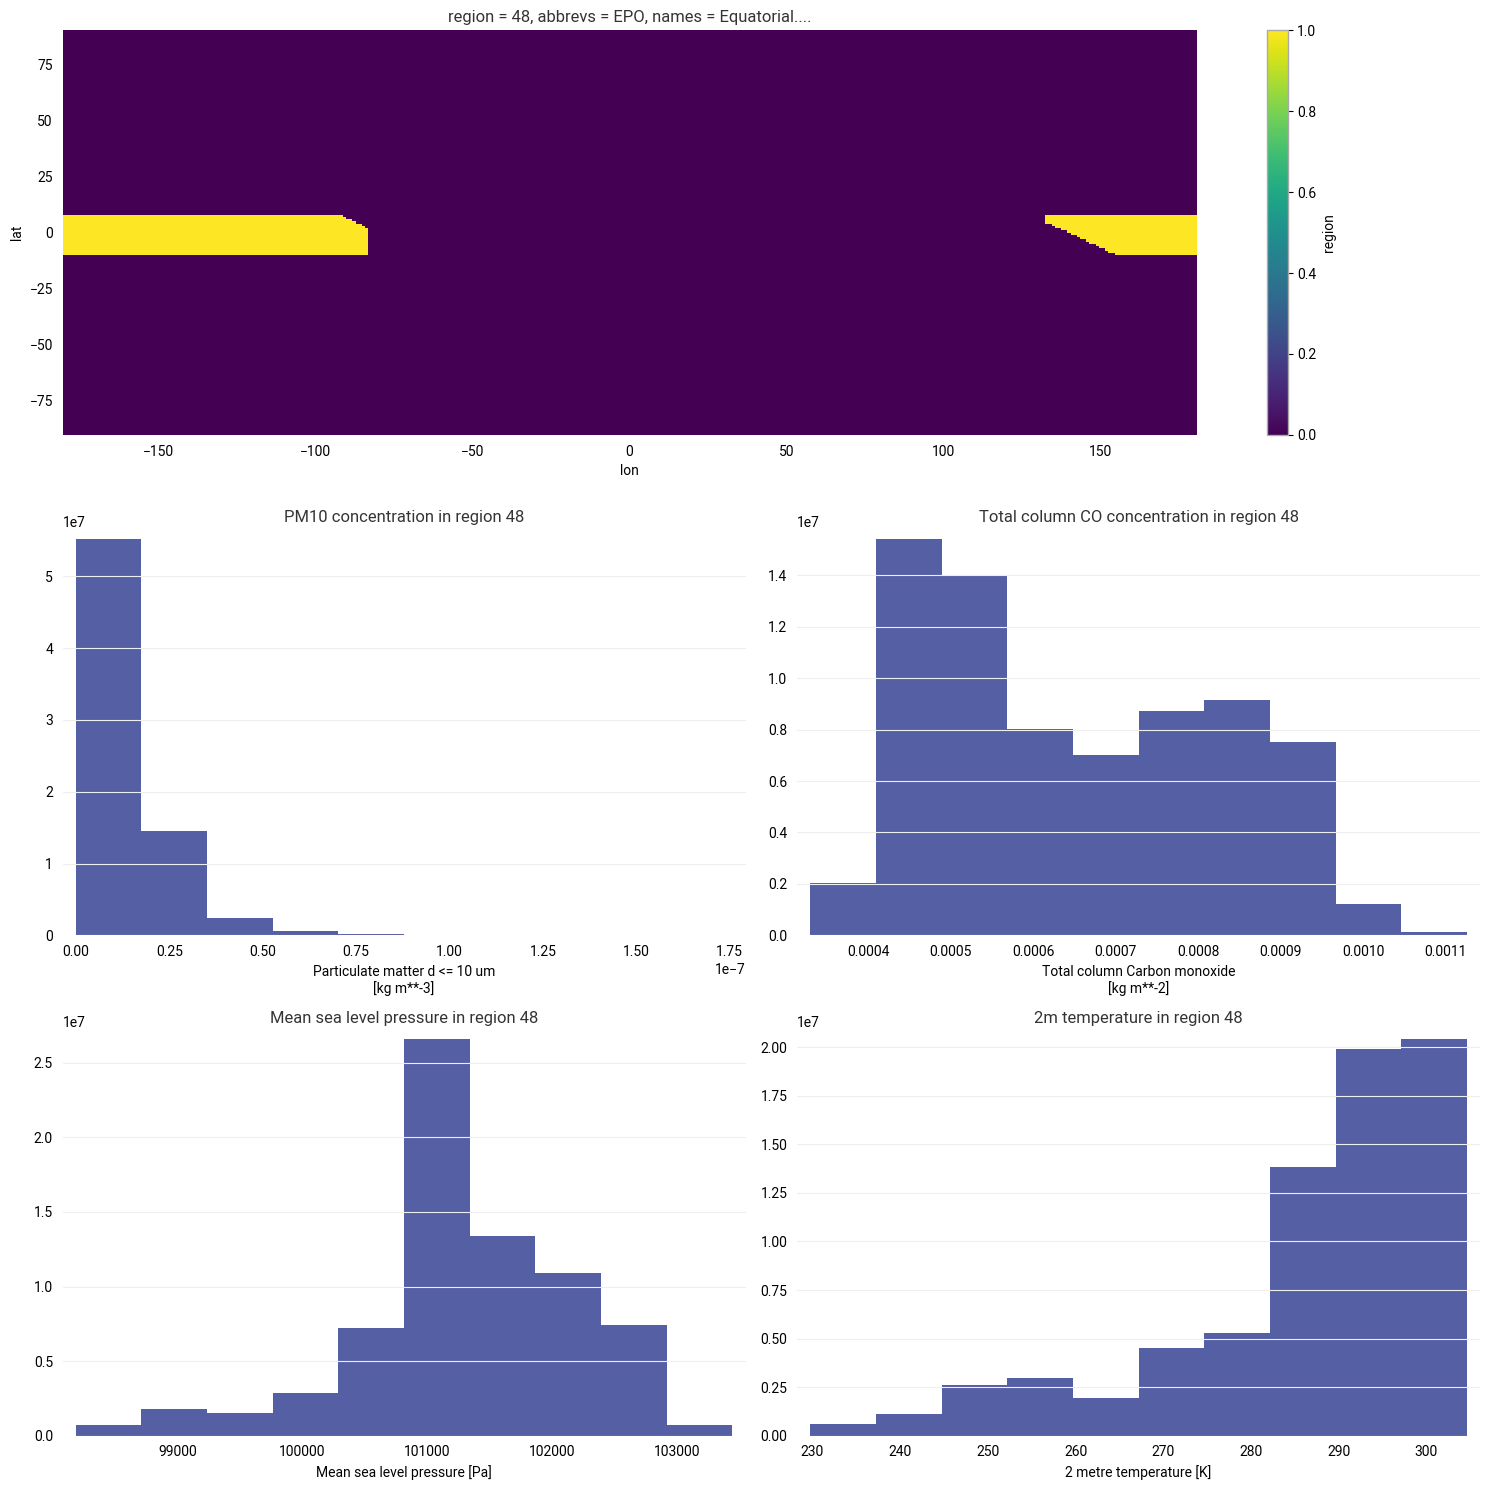

49 0 pm10 B
49 1 tcco C
49 2 msl D
49 3 t2m E


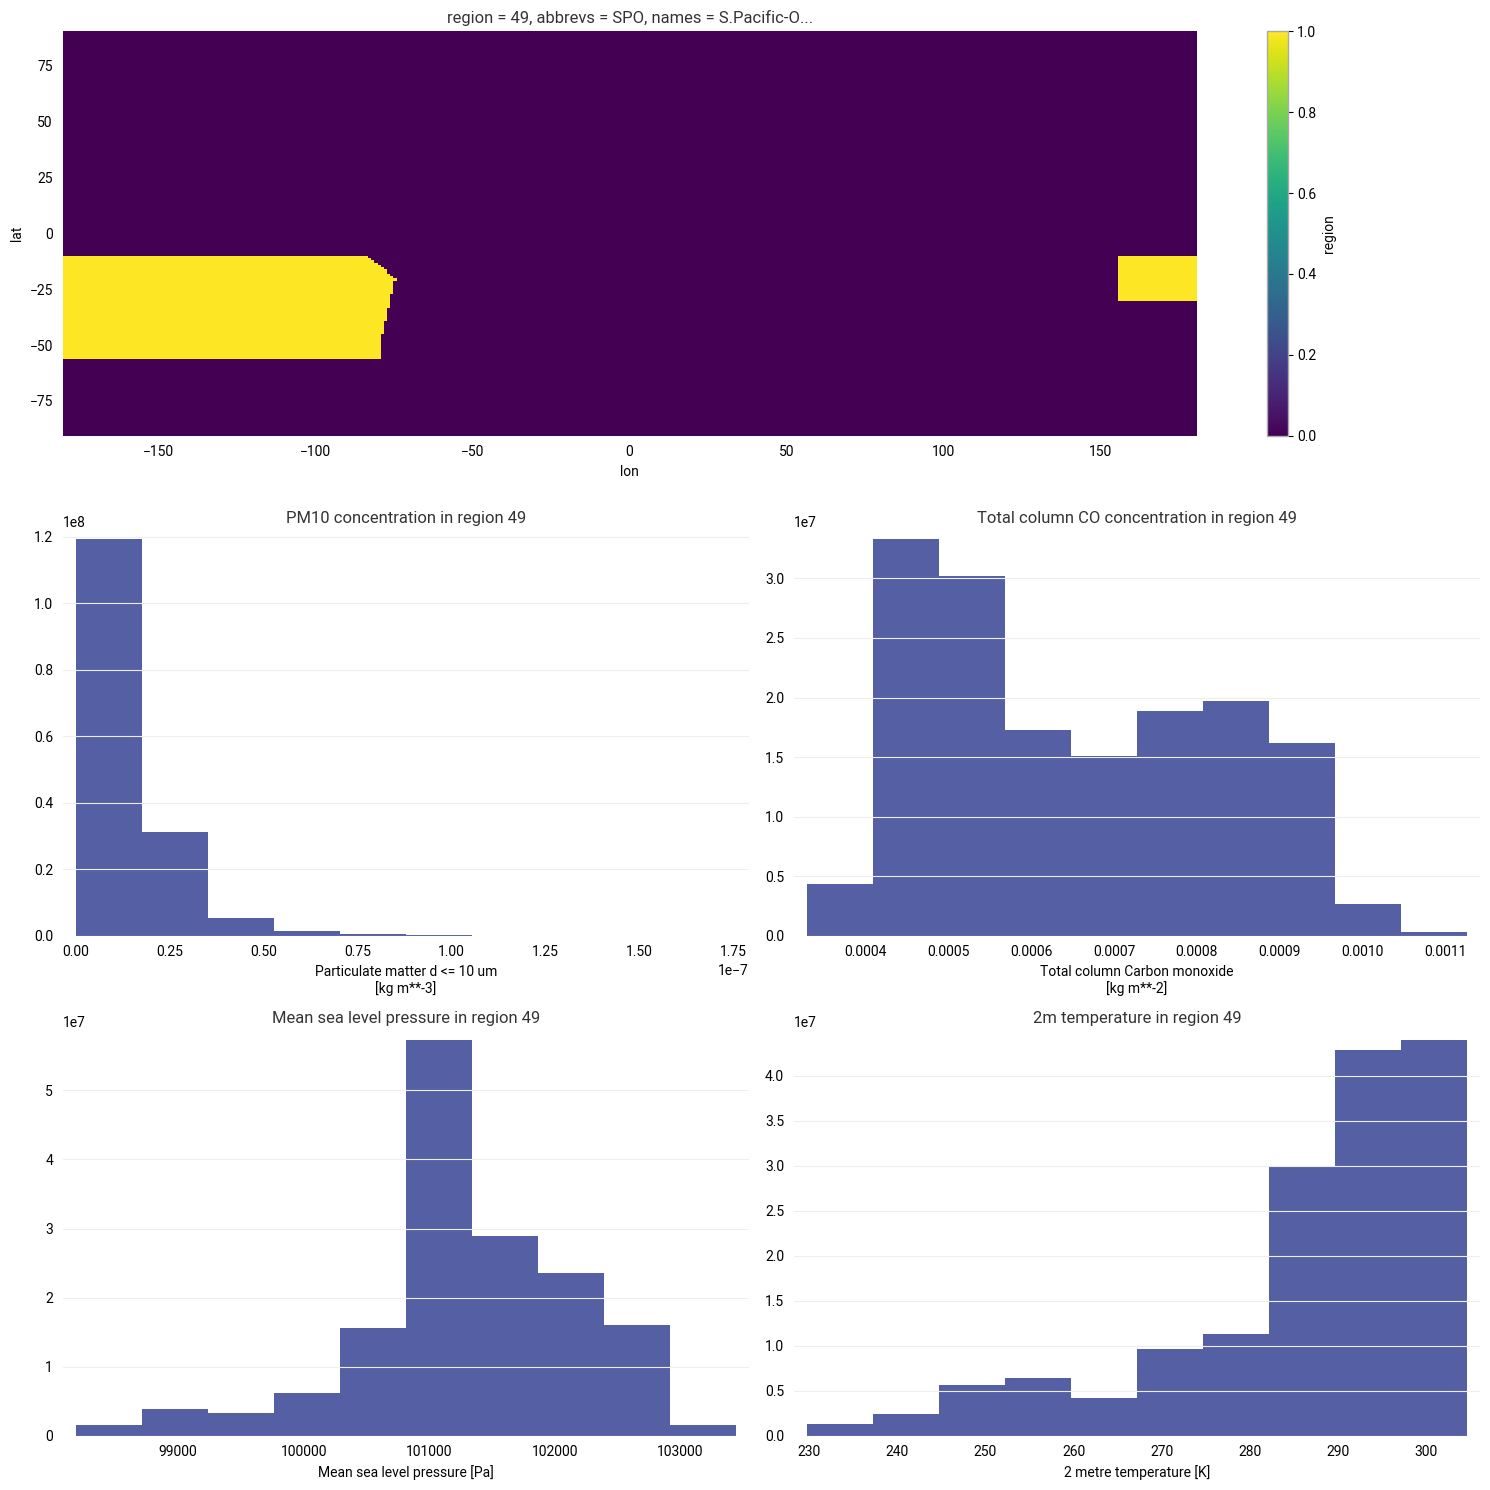

In [20]:
RELEVANT_LAND_REGIONS = [1, 3, 6, 7, 9, 13, 15]
RELEVANT_OCEAN_REGIONS = [47, 48, 49]

RELEVANT_REGIONS = RELEVANT_OCEAN_REGIONS # + RELEVANT_LAND_REGIONS

VARIABLE_NAMES = {
    "pm10": "PM10 concentration",
    "tcco": "Total column CO concentration",
    "msl": "Mean sea level pressure",
    "t2m": "2m temperature",
}

ds_path = '/tmp/tmptacb1_eq/ads-retriever-f5c106c0db93736042f233ebbd5bf5ef5119c7a4c943338308f26655ccc3399e.cache'
ds_xr = xr.open_dataset(ds_path, engine='cfgrib')

globe_xr = xr.Dataset(
    {
        "lon": (["lon"], np.linspace(-179.99, 180, 360)),
        "lat": (["lat"], np.linspace(-90, 90, 180)),
    }
)
ar6_mask = ar6_regions.mask_3D(globe_xr)


def plot_region_data(
    ds, 
    region_number, 
    variable,
    name=None,
    ax=None,
    global_mask=ar6_mask, 
):
    if ax is None:
        _, ax = plt.subplots()

    if name is None:
        name = variable
    
    region_mask = global_mask.sel(region=region_number)
    masked_ds = ds.where(region_mask)
    masked_ds[variable].plot(ax=ax)
    ax.set_title(f"{VARIABLE_NAMES[variable]} in region {region_number}")


time_idx = 0
for region_number in RELEVANT_REGIONS:
    fig, axs = plt.subplot_mosaic('AA;BC;DE', figsize=(15, 15))
    ax_keys = list(axs.keys())

    ar6_mask.sel(region=region_number).plot(ax=axs[ax_keys[0]])

    for i, (variable, name) in enumerate(VARIABLE_NAMES.items()):
        print(region_number, i, variable, ax_keys[i+1])
        plot_region_data(ds_xr.isel(time=time_idx), region_number, variable, name, axs[ax_keys[i+1]])
    
    plt.tight_layout()
    plt.show()

